🔍 Final Report
- Bits in Secret Image     : 131072
- Bits Embedded            : 131100
- Bits Extracted           : 131068
- PSNR                     : 47.40 dB
- MSE                      : 1.1833
- Blocks Used              : 116281


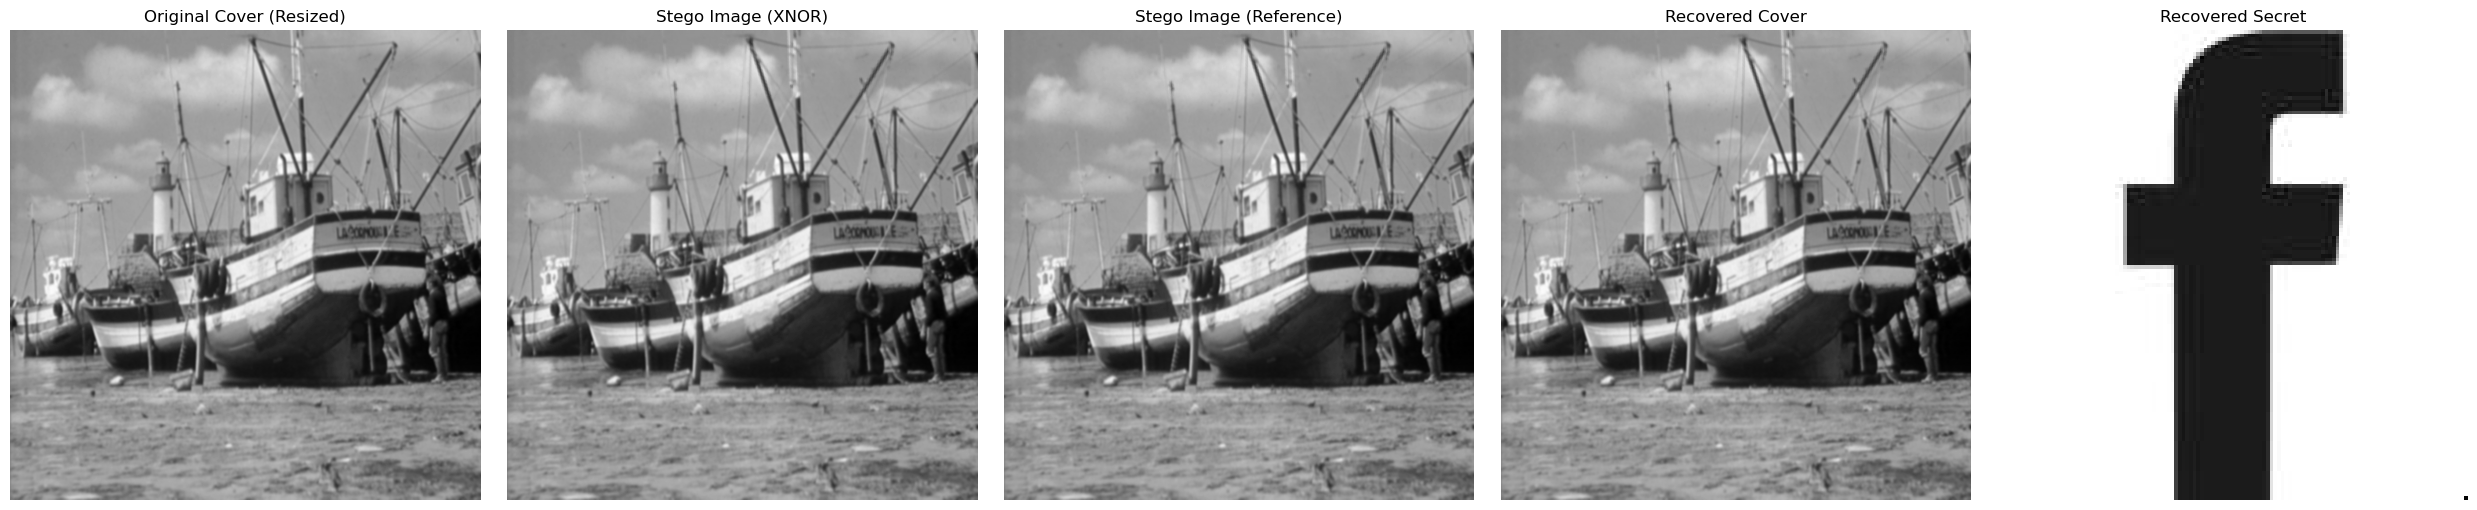

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse
from scipy.ndimage import gaussian_filter

# === Helper Functions ===
def brp(value):
    return int(format(value, '08b')[::-1], 2)

def ca_rule_90(center_pixel):
    bin_str = format(center_pixel, '08b')
    next_gen = ""
    for i in range(8):
        left = int(bin_str[i - 1]) if i > 0 else 0
        right = int(bin_str[i + 1]) if i < 7 else 0
        next_gen += str(left ^ right)
    return 2  # Fixed μ = 2 for better PSNR

def image_to_bitstream(img_array):
    return ''.join([format(pixel, '08b') for pixel in img_array.flatten()])

def bitstream_with_header(bits):
    length_bin = format(len(bits), '032b')
    return length_bin + bits

def low_pass_filter(image, sigma=1):
    return gaussian_filter(image, sigma=sigma).astype(np.uint8)

def xor_encrypt_decrypt(image, key=123):
    return np.bitwise_xor(image, key).astype(np.uint8)

def embed_block(block, bitstream, msg_index):
    AB_xnor = block.copy()
    AB_replace = block.copy()
    embedded_bits = ""
    pixel_pairs = [((0, 1), (0, 2)), ((1, 0), (1, 2)), ((2, 0), (2, 1)), ((2, 2), (0, 0))]

    mu = 2
    if msg_index + mu * 4 > len(bitstream):
        return block, block, "", msg_index

    AB_replace[1, 1] = (AB_replace[1, 1] & 0b11111100) | mu
    for (src, dst) in pixel_pairs:
        if msg_index + mu > len(bitstream):
            break
        secret_chunk = bitstream[msg_index: msg_index + mu]
        secret_val = int(secret_chunk, 2)
        src_val = block[src]
        brp_val = brp(src_val)
        gamma = brp_val + secret_val
        if gamma > 255:
            continue
        gamma_bin = format(gamma, '08b')
        brp_bin = format(brp_val, '08b')
        xnor_bin = ''.join(['1' if b == g else '0' for b, g in zip(brp_bin, gamma_bin)])
        AB_xnor[dst] = int(xnor_bin, 2)
        AB_replace[dst] = src_val
        embedded_bits += secret_chunk
        msg_index += mu

    return AB_xnor, AB_replace, embedded_bits, msg_index

def extract_block(xnor_block, replace_block, bit_budget):
    mu = 2
    extracted_bits = ""
    pixel_pairs = [((0, 1), (0, 2)), ((1, 0), (1, 2)), ((2, 0), (2, 1)), ((2, 2), (0, 0))]

    for (src, dst) in pixel_pairs:
        xnor_val = xnor_block[dst]
        src_val = replace_block[dst]
        brp_val = brp(src_val)
        brp_bin = format(brp_val, '08b')
        xnor_bin = format(xnor_val, '08b')
        gamma_bin = ''.join(['1' if b == x else '0' for b, x in zip(brp_bin, xnor_bin)])
        gamma = int(gamma_bin, 2)
        secret_val = gamma - brp_val
        if 0 <= secret_val < (1 << mu):
            bits = format(secret_val, f'0{mu}b')
            extracted_bits += bits
        if len(extracted_bits) >= bit_budget:
            break

    return extracted_bits, replace_block

# === Load Images ===
cover_img = cv2.imread("boat.512.tiff", cv2.IMREAD_GRAYSCALE)
secret_img = cv2.imread("128facebook.tiff", cv2.IMREAD_GRAYSCALE)

# Preprocess Cover and Secret
smoothed_cover_img = low_pass_filter(cover_img, sigma=1.0)
encrypted_secret_img = xor_encrypt_decrypt(secret_img, key=123)

# Resize cover image for capacity
height, width = cover_img.shape
resized_img = cv2.resize(smoothed_cover_img, (width * 2 - 1, height * 2 - 1), interpolation=cv2.INTER_CUBIC)

# Bitstream
secret_bitstream = image_to_bitstream(encrypted_secret_img)
bitstream = bitstream_with_header(secret_bitstream)

# === Embedding ===
stego_xnor = resized_img.copy()
stego_replace = resized_img.copy()
msg_index = 0
total_blocks = 0

for i in range(0, resized_img.shape[0] - 2, 3):
    for j in range(0, resized_img.shape[1] - 2, 3):
        if msg_index >= len(bitstream):
            break
        block = resized_img[i:i+3, j:j+3]
        AB_xnor, AB_replace, _, msg_index = embed_block(block, bitstream, msg_index)
        stego_xnor[i:i+3, j:j+3] = AB_xnor
        stego_replace[i:i+3, j:j+3] = AB_replace
        total_blocks += 1
    if msg_index >= len(bitstream):
        break

# === Extraction ===
extracted_bits = []
bit_count = 0
recovered_image = resized_img.copy()

for i in range(0, stego_xnor.shape[0] - 2, 3):
    for j in range(0, stego_xnor.shape[1] - 2, 3):
        xnor_block = stego_xnor[i:i+3, j:j+3]
        replace_block = stego_replace[i:i+3, j:j+3]
        bits, recovered_block = extract_block(xnor_block, replace_block, len(bitstream))
        extracted_bits.append(bits)
        bit_count += len(bits)
        recovered_image[i:i+3, j:j+3] = recovered_block
        if bit_count >= len(bitstream):
            break
    if bit_count >= len(bitstream):
        break

# === Recover Secret Image ===
recovered_bits = ''.join(extracted_bits)
payload_len = int(recovered_bits[:32], 2)
secret_data = recovered_bits[32:32 + payload_len]
pixels = [int(secret_data[i:i+8], 2) for i in range(0, len(secret_data), 8)]
pixels += [0] * (128 * 128 - len(pixels))
encrypted_secret_recovered = np.array(pixels, dtype=np.uint8).reshape(128, 128)
decrypted_secret_img = xor_encrypt_decrypt(encrypted_secret_recovered, key=123)

# === Save Output Images ===
Image.fromarray(resized_img).save("original_cover_resized.png")
Image.fromarray(stego_xnor).save("stego_xnor.png")
Image.fromarray(stego_replace).save("stego_replace.png")  # ⬅️ Added save for reference stego
Image.fromarray(recovered_image).save("recovered_cover.png")
Image.fromarray(decrypted_secret_img).save("recovered_secret.png")

# === Metrics ===
psnr_val = psnr(resized_img, recovered_image)
mse_val = mse(resized_img, recovered_image)
psnr_stego_vs_cover = psnr(resized_img, stego_replace)
mse_stego_vs_cover = mse(resized_img, stego_replace)

print("🔍 Final Report")
print(f"- Bits in Secret Image     : {len(secret_bitstream)}")
print(f"- Bits Embedded            : {msg_index}")
print(f"- Bits Extracted           : {len(secret_data)}")
print(f"- PSNR                     : {psnr_val:.2f} dB")
print(f"- MSE                      : {mse_val:.4f}")
print(f"- Blocks Used              : {total_blocks}")

# === Visualization (Now includes stego_replace) ===
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
titles = [
    "Original Cover (Resized)",
    "Stego Image (XNOR)",
    "Stego Image (Reference)",
    "Recovered Cover",
    "Recovered Secret"
]
images = [
    resized_img,
    stego_replace,
    stego_replace,
    recovered_image,
    decrypted_secret_img
]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
